<a href="https://colab.research.google.com/github/sayanbanerjee32/TSAI_ERAv2_S8/blob/main/S8_LN_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

#import from local modules
from utils import train, test, get_device, plot_accuracy_losses, plot_top_loss

# Check if GPU available

In [2]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [3]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [4]:
print(train_data_raw.data.shape)
print(train_data_raw.data.mean(axis=(0,1,2))/255)
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


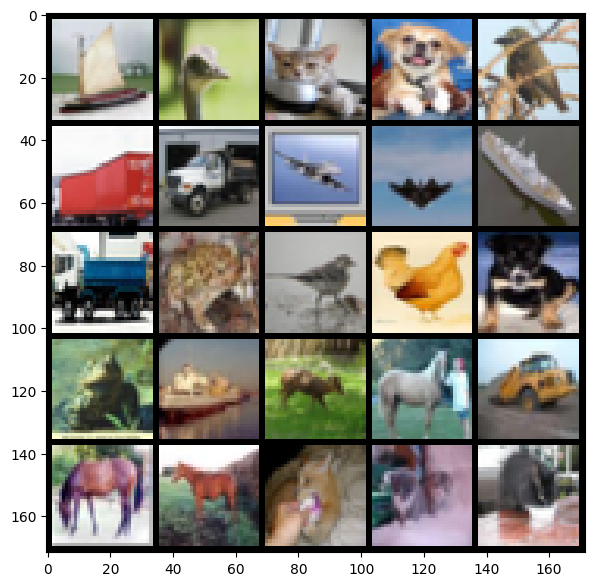

In [6]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [7]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


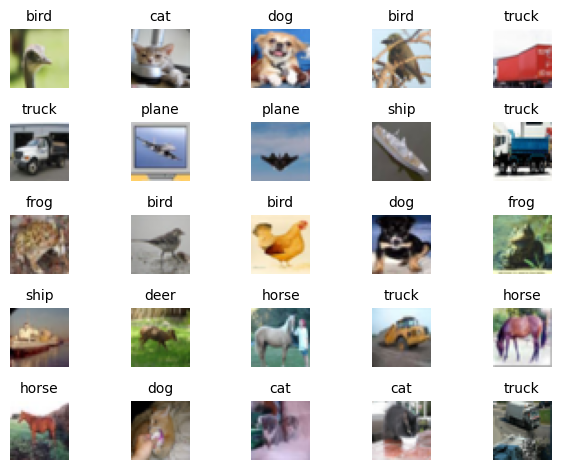

In [8]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                        # transforms.RandomApply([transforms.CenterCrop(22),], p=0.1),
                                        # transforms.Resize((28, 28)), # 99.08, 99.38
                                        # transforms.RandomApply([transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),], p=0.1), # 99.89, 99.36
                                        # transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),], p=0.1), # 98.60, 99.35
                                        transforms.RandomApply([transforms.RandomResizedCrop(size=(32, 32))], p=0.1),
                                        transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784)),
                                        # transforms.RandomErasing(p=0.1), #97.88, 99.32
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968,0.48215841,0.44653091), (0.24703223,0.24348513,0.26158784))
                                       ])

# Dataset and Creating Train/Test Split

In [10]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders

In [11]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

## Data Visualization

# Training

In [12]:
class Net(nn.Module):
    def __init__(self, n = 8, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32,32]),
            nn.Dropout(dropout_value)
        ) #input size: 28 x 28 x 1, output size: 26 x 26 x n, receptive field: 1 + (3-1) * 1 = 3

        # CONVOLUTION BLOCK 1
        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32,32]),
            nn.Dropout(dropout_value)
        ) #input size: 26 x 26 x n, output size: 24 x 24 x n*2, receptive field: 3 + (3-1) * 1 = 5

        # TRANSITION BLOCK 1
        self.c3 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([32,32]),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6
        self.p1 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6

        # CONVOLUTION BLOCK 2
        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16,16]),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16,16]),
            nn.Dropout(dropout_value)
        ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16,16]),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

        # TRANSITION BLOCK 2
        self.c7 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([16,16]),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n*2, output size: 12 x 12 x n, receptive field: 6 + (1-1)*2 = 6
        self.p2 = nn.MaxPool2d(2, 2) #input size: 24 x 24 x n*2, output size: 12 x 12 x n*2, receptive field: 5 + (2-1) * 1 = 6


        # CONVOLUTION BLOCK 3
        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=n, out_channels=n*2,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8,8]),
            nn.Dropout(dropout_value)
        ) #input size: 12 x 12 x n, output size: 10 x 10 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C9 = nn.Sequential(
            nn.Conv2d(in_channels=n*2, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8,8]),
            nn.Dropout(dropout_value)
        ) #input size: 10 x 10 x n*2, output size: 8 x 8 x n*2, receptive field: 10 + (3-1) * 2 = 14

        self.C10 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=n*4,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.LayerNorm([8,8]),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 6 x 6 x n*2, receptive field: 14 + (3-1) * 2 = 18

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            # nn.AvgPool2d(kernel_size=7) # 7>> 9...
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 6 x 6 x n*2, output size: 1 x 1 x n*2, receptive field: 18

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=n*4, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
            # nn.LayerNorm(10),
            # nn.ReLU()
        ) #input size: 1 x 1 x n*2, output size: 1 x 1 x 10, receptive field: 18 + (1-1) * 2 =18



    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)

        x = self.c3(x)
        x = self.p1(x)

        x = self.C4(x)
        x = self.C5(x)
        x = self.C6(x)

        x = self.c7(x)
        x = self.p2(x)

        x = self.C8(x)
        x = self.C9(x)
        x = self.C10(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)

In [13]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         LayerNorm-3           [-1, 16, 32, 32]           2,048
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         LayerNorm-7           [-1, 32, 32, 32]           2,048
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             256
             ReLU-10            [-1, 8, 32, 32]               0
        LayerNorm-11            [-1, 8, 32, 32]           2,048
          Dropout-12            [-1, 8, 32, 32]               0
        MaxPool2d-13            [-1, 8, 16, 16]               0
           Conv2d-14           [-1, 16,

In [14]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [15]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9) # reduce learning rate, loss not converging
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 2,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=1.8699 Batch_id=390 Accuracy=17.87: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]


Test set: Average loss: 1.9147, Accuracy: 2932/10000 (29.32%)

Epoch 2


Train: Loss=1.7065 Batch_id=390 Accuracy=37.05: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]


Test set: Average loss: 1.5406, Accuracy: 4401/10000 (44.01%)

Epoch 3


Train: Loss=1.4274 Batch_id=390 Accuracy=44.95: 100%|██████████| 391/391 [00:22<00:00, 17.70it/s]


Test set: Average loss: 1.4147, Accuracy: 4856/10000 (48.56%)

Epoch 4


Train: Loss=1.3277 Batch_id=390 Accuracy=49.26: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s]


Test set: Average loss: 1.2731, Accuracy: 5427/10000 (54.27%)

Epoch 5


Train: Loss=1.3045 Batch_id=390 Accuracy=52.57: 100%|██████████| 391/391 [00:23<00:00, 16.73it/s]


Test set: Average loss: 1.2150, Accuracy: 5649/10000 (56.49%)

Epoch 6


Train: Loss=1.2934 Batch_id=390 Accuracy=54.67: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s]


Test set: Average loss: 1.1639, Accuracy: 5859/10000 (58.59%)

Epoch 7


Train: Loss=1.0919 Batch_id=390 Accuracy=56.47: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s]


Test set: Average loss: 1.1141, Accuracy: 6017/10000 (60.17%)

Epoch 8


Train: Loss=1.1933 Batch_id=390 Accuracy=58.19: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s]


Test set: Average loss: 1.0921, Accuracy: 6147/10000 (61.47%)

Epoch 9


Train: Loss=1.2495 Batch_id=390 Accuracy=59.05: 100%|██████████| 391/391 [00:22<00:00, 17.55it/s]


Test set: Average loss: 1.0537, Accuracy: 6221/10000 (62.21%)

Epoch 10


Train: Loss=1.1706 Batch_id=390 Accuracy=60.14: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s]


Test set: Average loss: 1.0051, Accuracy: 6497/10000 (64.97%)

Epoch 11


Train: Loss=0.9599 Batch_id=390 Accuracy=60.90: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s]


Test set: Average loss: 1.0305, Accuracy: 6364/10000 (63.64%)

Epoch 12


Train: Loss=0.9658 Batch_id=390 Accuracy=61.46: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s]


Test set: Average loss: 0.9786, Accuracy: 6501/10000 (65.01%)

Epoch 13


Train: Loss=0.9310 Batch_id=390 Accuracy=62.21: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s]


Test set: Average loss: 0.9748, Accuracy: 6569/10000 (65.69%)

Epoch 14


Train: Loss=0.9162 Batch_id=390 Accuracy=62.92: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Test set: Average loss: 0.9246, Accuracy: 6750/10000 (67.50%)

Epoch 15


Train: Loss=1.0738 Batch_id=390 Accuracy=63.19: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s]


Test set: Average loss: 0.9588, Accuracy: 6659/10000 (66.59%)

Epoch 16


Train: Loss=1.0151 Batch_id=390 Accuracy=63.65: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s]


Test set: Average loss: 0.9275, Accuracy: 6729/10000 (67.29%)

Epoch 17


Train: Loss=1.0185 Batch_id=390 Accuracy=63.77: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s]


Test set: Average loss: 0.9268, Accuracy: 6729/10000 (67.29%)

Epoch 18


Train: Loss=1.0942 Batch_id=390 Accuracy=66.13: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s]


Test set: Average loss: 0.8663, Accuracy: 6959/10000 (69.59%)

Epoch 19


Train: Loss=0.8532 Batch_id=390 Accuracy=66.59: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s]


Test set: Average loss: 0.8433, Accuracy: 7020/10000 (70.20%)

Epoch 20


Train: Loss=0.9518 Batch_id=390 Accuracy=66.56: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s]


Test set: Average loss: 0.8414, Accuracy: 7055/10000 (70.55%)



In [16]:
# final learning rate
scheduler.get_last_lr()

[0.010000000000000002]

## Visualise training and test losses and accuracies

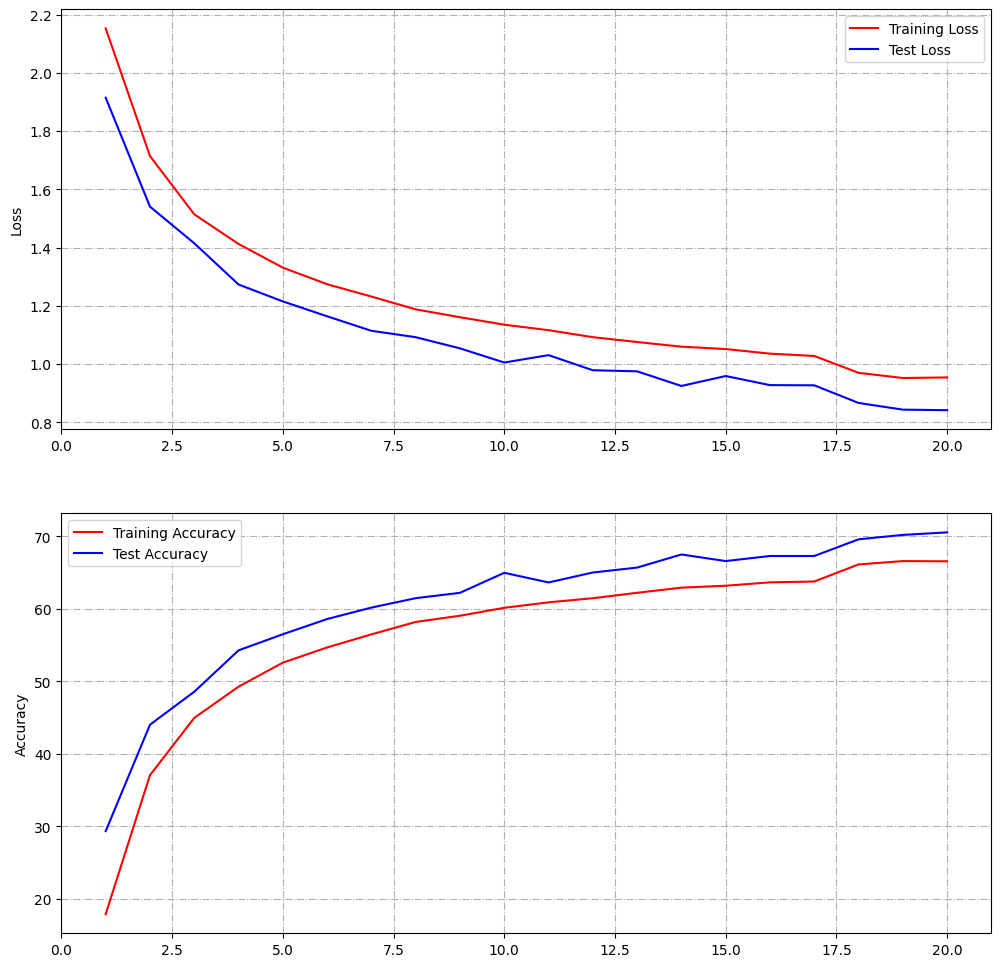

In [17]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs)

## Error analysis

total wrong predictions: 2945


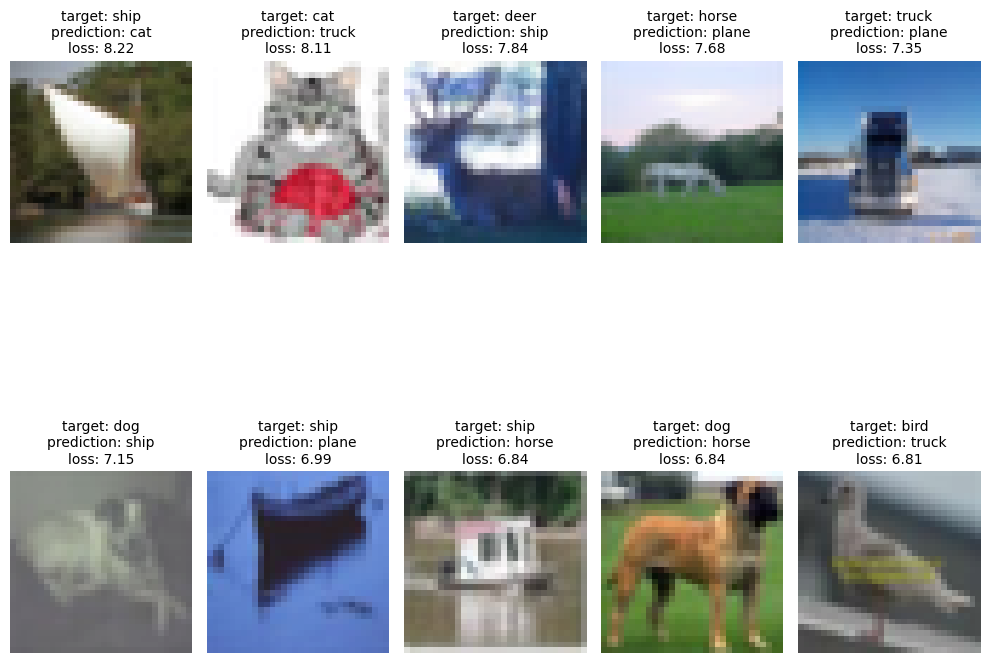

In [18]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=2, img_cols = 5)

In [19]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
21,cat,dog,1.420274,228
38,dog,cat,1.376475,142
32,deer,horse,1.834592,129
3,bird,dog,1.998180,103
58,horse,dog,1.869215,86
...,...,...,...,...
50,frog,horse,2.518160,3
13,car,frog,2.810272,3
65,plane,deer,1.366611,3
59,horse,frog,2.805399,2
